In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sb
from pylab import rcParams

import scipy
from scipy.stats.stats import pearsonr

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 7
plt.style.use('seaborn-whitegrid')

importing the data

In [3]:
df = pd.read_csv('games.csv')
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


dropping the columns: 'Start time', 'End time', 'white player ID', 'Black player ID' since they are  not relevant for our analysis from here on.

In [4]:
df = df.drop(columns = ['created_at', 'last_move_at', 'white_id', 'black_id'])
df.head(5)

,id,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Since we want to predict the winner, we are setting it as 'y' and the rest of the features as X

In [5]:
X = df.drop(columns = ['winner'])
y = df.winner

Getting the number of unique values for each categorical features

In [6]:
for col_name in X.columns:
    if X[col_name].dtype == 'object':
        unique_cat = len(X[col_name].unique())
        print(f"Feature '{col_name}' has {unique_cat} unique categories")

Feature 'id' has 19113 unique categories
Feature 'victory_status' has 4 unique categories
Feature 'increment_code' has 400 unique categories
Feature 'moves' has 18920 unique categories
Feature 'opening_eco' has 365 unique categories
Feature 'opening_name' has 1477 unique categories


In [7]:
df['opening_eco'].value_counts()

A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
D13       1
E35       1
B60       1
D82       1
E72       1
Name: opening_eco, Length: 365, dtype: int64

Checking fro missing Values

In [8]:
X.isnull().sum().sort_values(ascending=False).head

<bound method NDFrame.head of opening_ply       0
opening_name      0
opening_eco       0
moves             0
black_rating      0
white_rating      0
increment_code    0
victory_status    0
turns             0
rated             0
id                0
dtype: int64>

comparison of winner based on color

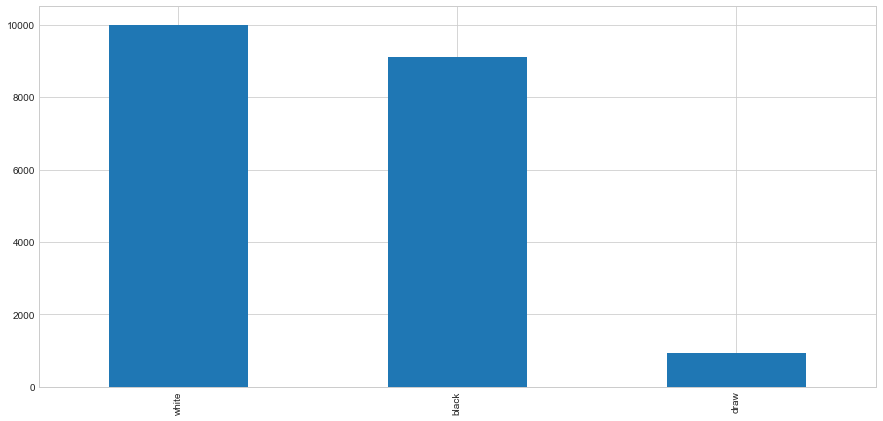

In [9]:
y.value_counts().plot(kind = 'bar')

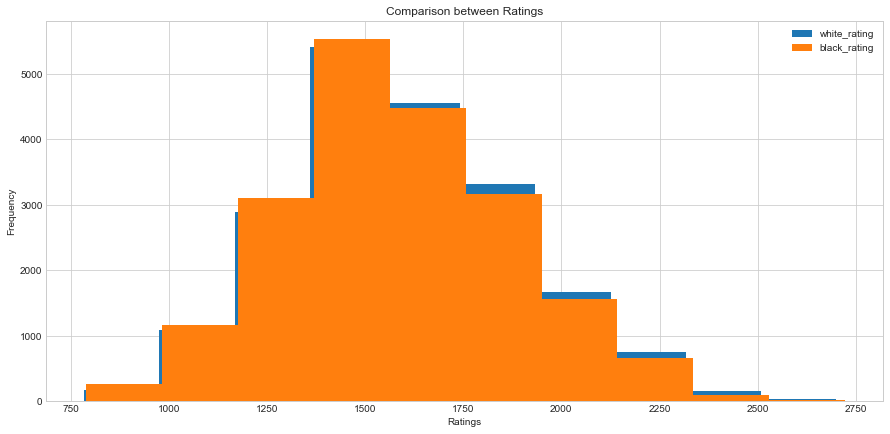

In [10]:
X['white_rating'].plot(kind = 'hist')
X['black_rating'].plot(kind = 'hist')
plt.title("Comparison between Ratings")
plt.legend(loc='upper right')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
#plt.savefig('rating_comp.png')
plt.show()

For ease of classiification, let's use the Elo Scale to discritize the ratings of the players, which is as follow

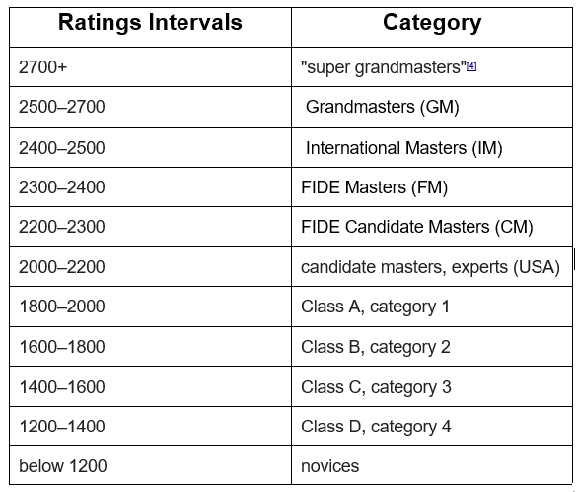


In [11]:
bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3000]

category = ['Novices', 'Class D', 'Class C', 'Class B', 'Class A', 'Expert', 'CM', 'FM', 'IM', 'GM', 'Super GM']

X['white_ratings_interval'] = pd.cut(df['white_rating'], bins, labels = category)
X['black_ratings_interval'] = pd.cut(df['black_rating'], bins, labels = category)
X.head(3)

,id,rated,turns,victory_status,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,white_ratings_interval,black_ratings_interval
0,TZJHLljE,False,13,outoftime,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,Class C,Novices
1,l1NXvwaE,True,16,resign,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,Class D,Class D
2,mIICvQHh,True,61,mate,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,Class C,Class C


### Comparing the ratings of the Black and White Players

First let's find the frequency for each rating category by color of players

In [12]:
bars1 = X['white_ratings_interval'].value_counts()
bars2 = X['black_ratings_interval'].value_counts()

print('Rating Category Frequency of White players:')
print(bars1)
print("\n\n")
print('Rating Category Frequency of Black players:')
print(bars2)

Rating Category Frequency of White players:
Class C     5775
Class B     4333
Class D     3490
Class A     3061
Novices     1605
Expert      1215
CM           363
FM            98
IM            78
GM            40
Super GM       0
Name: white_ratings_interval, dtype: int64



Rating Category Frequency of Black players:
Class C     5772
Class B     4288
Class D     3569
Class A     2941
Novices     1704
Expert      1259
CM           345
FM           107
IM            49
GM            23
Super GM       1
Name: black_ratings_interval, dtype: int64


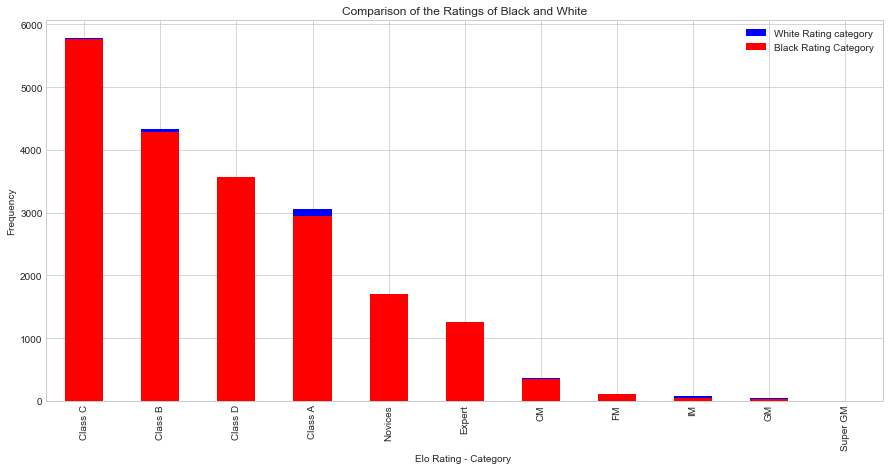

In [13]:
X['white_ratings_interval'].value_counts().plot(kind = 'bar', label = 'White Rating category', color = 'blue' , align ='center')
X['black_ratings_interval'].value_counts().plot(kind = 'bar', label = 'Black Rating Category', color = 'red', align = 'center')
plt.xlabel('Elo Rating - Category ')
plt.ylabel('Frequency')
plt.title('Comparison of the Ratings of Black and White')
plt.legend(loc = 'upper right')
plt.show()



([<matplotlib.axis.XTick at 0x18498689730>,
 [Text(0, 0, 'Class C'),
  Text(0, 0, 'Class B'),
  Text(0, 0, 'Class D'),
  Text(0, 0, 'Class A'),
  Text(0, 0, 'Novices'),
  Text(0, 0, 'Expert'),
  Text(0, 0, 'CM'),
  Text(0, 0, 'FM'),
  Text(0, 0, 'IM'),
  Text(0, 0, 'GM'),
  Text(0, 0, 'super GM')])

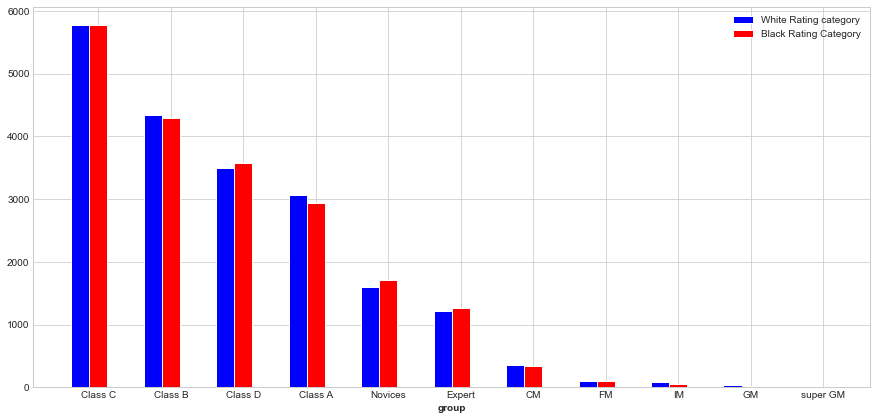

In [14]:
w = 0.25
rp1 = np.arange(len(bars1))
rp2 = [x + w for x in rp1]

plt.bar(rp1, bars1, color='blue', width=w, edgecolor='white', label='White Rating category')
plt.bar(rp2, bars2, color='red', width=w, edgecolor='white', label='Black Rating Category')
plt.legend(loc = 'upper right')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + w for r in range(len(bars1))], ['Class C', 'Class B', 'Class D', 'Class A', 'Novices', 'Expert', 'CM', 'FM', 'IM', 'GM', 'super GM'])



In [15]:
x1 = df[df['winner']=='white'].shape[0]
x2 = df[df['winner']=='black'].shape[0]
x3 = df[df['winner']=='draw'].shape[0]
print("Number of white player that won: ", x1)
print("Number of Black player that won: ", x2)
print("Number of drawn game: ", x3)

Number of white player that won:  10001
Number of Black player that won:  9107
Number of drawn game:  950


In [16]:
#Number of white player rated higher than the black player
x1 = df[df['white_rating'] > df['black_rating']].shape[0]

#number of black player rated higher than the white player
x2 = df[df['white_rating'] < df['black_rating']].shape[0]

#number of equal rating
x3 = df[df['white_rating'] == df['black_rating']].shape[0]


print("Number of games where the white player rated higher than the black player: ", x1)
print("Number of games where the Black player rated higher than the white player: ", x2)
print("Number of games where both players are of the same ratings: ", x3)

Number of games where the white player rated higher than the black player:  10184
Number of games where the Black player rated higher than the white player:  9671
Number of games where both players are of the same ratings:  203


In [17]:
temp = df[df['winner']=='white']
x1 = temp[temp['white_rating'] > temp['black_rating']].shape[0]
x2 = temp[temp['white_rating'] < temp['black_rating']].shape[0]
x3 = temp[temp['white_rating'] == temp['black_rating']].shape[0]

print("Number of games where the white player won given white player is rated higher: ", x1)
print("Number of games where the white player won given black player is rated higher: ", x2)
print("Number of games where the white player won given both players are of the same ratings: ", x3)

Number of games where the white player won given white player is rated higher:  6529
Number of games where the white player won given black player is rated higher:  3377
Number of games where the white player won given both players are of the same ratings:  95


In [18]:
temp = df[df['winner']=='black']
x1 = temp[temp['white_rating'] > temp['black_rating']].shape[0]
x2 = temp[temp['white_rating'] < temp['black_rating']].shape[0]
x3 = temp[temp['white_rating'] == temp['black_rating']].shape[0]

print("Number of games where the black player won given white player is rated higher: ", x1)
print("Number of games where the black player won given black player is rated higher: ", x2)
print("Number of games where the black player won given both players are of the same ratings: ", x3)

Number of games where the black player won given white player is rated higher:  3189
Number of games where the black player won given black player is rated higher:  5823
Number of games where the black player won given both players are of the same ratings:  95


In [19]:
temp = df[df['winner']=='draw']
x1 = temp[temp['white_rating'] > temp['black_rating']].shape[0]
x2 = temp[temp['white_rating'] < temp['black_rating']].shape[0]
x3 = temp[temp['white_rating'] == temp['black_rating']].shape[0]

print("Number of games that ended in a draw given white player is rated higher: ", x1)
print("Number of games that ended in a draw given black player is rated higher: ", x2)
print("Number of games that ended in a draw given both players are of the same ratings: ", x3)

Number of games that ended in a draw given white player is rated higher:  466
Number of games that ended in a draw given black player is rated higher:  471
Number of games that ended in a draw given both players are of the same ratings:  13


### Summary

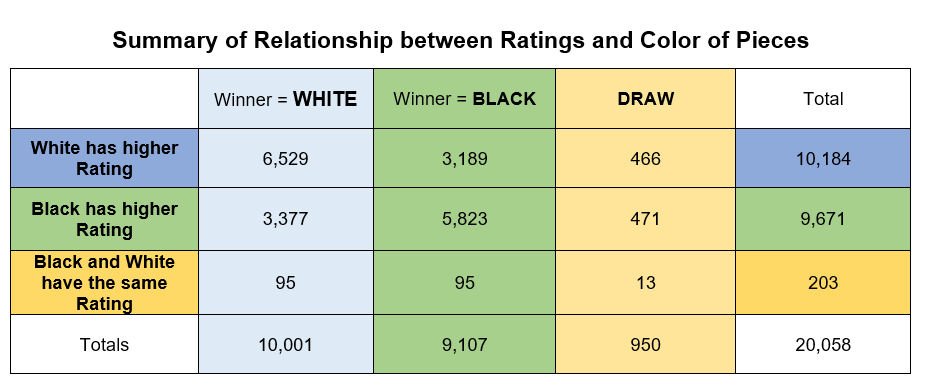

In [20]:
from IPython.display import Image
Image(filename = 'rating_color_summary.PNG')

Checking for favorable openning for each player

In [21]:
a = df.groupby('winner').opening_eco.value_counts()
a

winner  opening_eco
black   A00            570
        C00            389
        D00            360
        C20            355
        B01            332
                      ... 
white   E68              1
        E87              1
        E92              1
        E95              1
        E97              1
Name: opening_eco, Length: 828, dtype: int64

In [22]:
a1 = df[df['winner'] == 'white']['opening_eco'].value_counts()
a2 = df[df['winner'] == 'black']['opening_eco'].value_counts()

print("top 10 most successful opening by the white player: ")
print(a1.head(20))
print("\n")
print("top 10 most successful opening by the black player: ")
print(a2.head(20))


top 10 most successful opening by the white player: 
C00    417
A00    398
C41    396
B00    365
B01    358
D00    341
A40    338
C20    299
C40    266
C50    240
B20    223
D02    222
C44    195
C42    179
B07    169
C55    165
A04    156
C46    149
C45    143
C02    132
Name: opening_eco, dtype: int64


top 10 most successful opening by the black player: 
A00    570
C00    389
D00    360
C20    355
B01    332
B20    320
C50    268
C41    267
A40    261
B00    218
D02    193
C44    174
C40    167
C42    135
A45    134
C55    131
C02    131
C45    128
B30    123
B07    117
Name: opening_eco, dtype: int64


In [23]:
a1 = df[df['winner'] == 'white']
a1 = a1[a1['white_rating'] > a1['black_rating']].opening_eco.value_counts()

a2 = df[df['winner'] == 'white']
a2 = a2[a2['white_rating'] < a2['black_rating']].opening_eco.value_counts()

a3 = df[df['winner'] == 'white']
a3 = a3[a3['white_rating'] == a3['black_rating']].opening_eco.value_counts()


print("top 10 most successful opening by the white player when white player is rated higher: ")
print(a1.head(10))
print("\n")
print("top 10 most successful opening by the white player when black player is rated higher: ")
print(a2.head(10))
print("\n")
print("top 10 most successful opening by the white player when both have the same ratings: ")
print(a3.head(10))

top 10 most successful opening by the white player when white player is rated higher: 
C00    278
C41    275
B00    261
A40    249
A00    248
B01    237
D00    224
C40    184
C20    175
C50    159
Name: opening_eco, dtype: int64


top 10 most successful opening by the white player when black player is rated higher: 
A00    149
C00    136
B01    117
C20    116
C41    116
D00    111
B20    105
B00     99
A40     87
C40     80
Name: opening_eco, dtype: int64


top 10 most successful opening by the white player when both have the same ratings: 
C20    8
D00    6
B00    5
C41    5
B01    4
C50    4
C44    4
B20    4
C00    3
C30    3
Name: opening_eco, dtype: int64


In [24]:
a1 = df[df['winner'] == 'black']
a1 = a1[a1['white_rating'] > a1['black_rating']].opening_eco.value_counts()

a2 = df[df['winner'] == 'black']
a2 = a2[a2['white_rating'] < a2['black_rating']].opening_eco.value_counts()

a3 = df[df['winner'] == 'black']
a3 = a3[a3['white_rating'] == a3['black_rating']].opening_eco.value_counts()


print("top 10 most successful opening by the black player when white player is rated higher: ")
print(a1.head(10))
print("\n")
print("top 10 most successful opening by the black player when black player is rated higher: ")
print(a2.head(10))
print("\n")
print("top 10 most successful opening by the black player when both have the same ratings: ")
print(a3.head(10))

top 10 most successful opening by the black player when white player is rated higher: 
C00    144
A00    132
B01    115
D00    113
A40    106
C20    105
C41    104
C50     98
B00     95
C44     87
Name: opening_eco, dtype: int64


top 10 most successful opening by the black player when black player is rated higher: 
A00    430
D00    247
C20    244
C00    241
B20    229
B01    211
C50    167
C41    159
A40    152
B00    120
Name: opening_eco, dtype: int64


top 10 most successful opening by the black player when both have the same ratings: 
A00    8
B20    6
C20    6
B01    6
C02    5
C00    4
C41    4
C50    3
B00    3
C23    3
Name: opening_eco, dtype: int64


In [25]:
temp = df.copy()
l1 = ['white' if temp ['white_rating'][i]>temp ['black_rating'][i] else 'black' for i in range(temp.shape[0])]
l2 = [abs(temp ['white_rating'][i] - temp['black_rating'][i]) for i in range(temp.shape[0])]
temp['black_ratings_interval'] = X['black_ratings_interval']
temp['white_ratings_interval'] = X['white_ratings_interval']
temp ['higher'] = l1
temp['rating_difference'] = l2
temp = temp[temp['black_ratings_interval']!=temp['white_ratings_interval']]
diff_df = temp[['white_rating', 'black_rating', 'white_ratings_interval','black_ratings_interval', 'rating_difference',  'higher']].copy()


diff_df.head(5)

,white_rating,black_rating,white_ratings_interval,black_ratings_interval,rating_difference,higher
0,1500,1191,Class C,Novices,309,white
5,1250,1002,Class D,Novices,248,white
7,1413,2108,Class C,Expert,695,black
8,1439,1392,Class C,Class D,47,white
11,1381,1867,Class D,Class A,486,black


In [26]:
diff_df['rating_difference'].value_counts()

108     60
166     53
189     50
130     48
213     46
        ..
571      1
3        1
1090     1
970      1
1499     1
Name: rating_difference, Length: 891, dtype: int64

In [27]:
b = [50*i for i in range(21)]
b.append(3000)
c = [str(50*i)+'-'+str(50*(i+1)) for i in range(20)]
c.append('over 1000')
temp['rating_difference_interval'] = pd.cut(temp['rating_difference'], b, labels=c)


diff_df['rating_difference_interval'] = temp['rating_difference_interval'].copy()
diff_df['winner'] = temp['winner'].copy()
diff_df

,white_rating,black_rating,white_ratings_interval,black_ratings_interval,rating_difference,higher,rating_difference_interval,winner
0,1500,1191,Class C,Novices,309,white,300-350,white
5,1250,1002,Class D,Novices,248,white,200-250,draw
7,1413,2108,Class C,Expert,695,black,650-700,black
8,1439,1392,Class C,Class D,47,white,0-50,black
11,1381,1867,Class D,Class A,486,black,450-500,black
...,...,...,...,...,...,...,...,...
20042,1759,1265,Class B,Class D,494,white,450-500,white
20044,1523,1256,Class C,Class D,267,white,250-300,white
20050,1243,1142,Class D,Novices,101,white,100-150,white
20053,1691,1220,Class B,Class D,471,white,450-500,white


In [28]:
diff_df['rating_difference_interval'].value_counts()

100-150      1693
150-200      1617
200-250      1486
50-100       1269
250-300      1132
300-350       856
350-400       654
0-50          557
400-450       511
450-500       371
500-550       368
550-600       190
600-650       173
650-700       114
700-750       108
750-800        68
800-850        67
over 1000      62
950-1000       46
850-900        29
900-950        24
Name: rating_difference_interval, dtype: int64

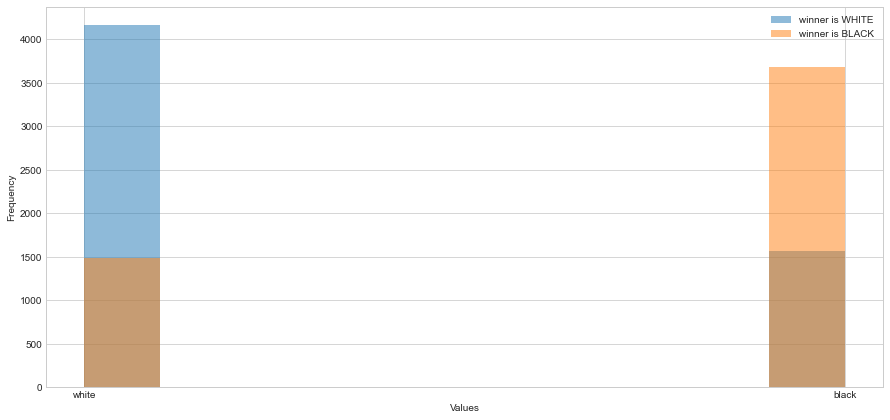

In [29]:
plt.hist(list(diff_df[diff_df['winner']=='white']['higher']), alpha=0.5, label = 'winner is WHITE')
plt.hist(list(diff_df[diff_df['winner']=='black']['higher']), alpha=0.5, label = 'winner is BLACK')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [30]:
diff_outcome=diff_df.groupby(['winner', 'higher']).rating_difference_interval.value_counts()
diff_outcome.head(40)

winner  higher  rating_difference_interval
black   black   200-250                       524
                150-200                       480
                100-150                       471
                250-300                       364
                50-100                        330
                300-350                       323
                350-400                       256
                400-450                       182
                500-550                       147
                450-500                       135
                0-50                          117
                550-600                        70
                600-650                        66
                650-700                        47
                700-750                        44
                800-850                        30
                750-800                        26
                over 1000                      20
                950-1000                       18
       

In [31]:
diff_df['turns'] = df['turns'].copy()
a = diff_df['turns'].unique()
a

array([ 13,   5,   9,  66,  38,  60,  31, 101,  25,  14,  17,  36,  69,
        43,  54,  64,  21,  11,  19,  28,  22,  37,  34,  32,  71,  30,
        41,  49,   3,   7,  35,  53,   8,  44,  40,  39,  87, 131,  48,
        47,  57,  58,  62,  85,  75, 135,  81,  46,  70, 137,  33,  90,
        50,  59,  23, 120,  24,  95,   2, 156,  18,  77,  65, 136, 106,
        15, 118,  73, 159, 112, 104, 150,  88,  97,  55,  20,  42, 177,
       114,  99,  74,  80,  72,   6,  96,  78,  27, 102,  45,  98, 108,
        92, 123, 129, 111, 119,  10, 163,  52,  67, 130, 125, 116,  76,
       110, 148,  29, 195,  63, 107, 122, 128,  51,  79,  26, 105, 115,
       133, 158,  61,  86,  84,  56,  83, 100,  89,  82,  68,   4, 178,
       153, 103,  16, 154, 113, 160,  12, 124,  94, 132, 141, 117, 127,
       109,  93,  91,   1, 171, 145, 179, 143, 149, 140, 134, 169, 155,
       164, 121, 138, 126, 157, 190, 146, 147, 139, 144, 176, 172, 188,
       168, 151, 152, 184, 162, 142, 161, 189, 166, 165, 170, 17

In [32]:
l1 = [5*i for i in range(44)]
l2 = [str(5*i)+'-'+str(5*(i+1))  for i in range(42)]
l2.append('over 210 moves')


diff_df['moves_interval'] = pd.cut(diff_df['turns'], l1, labels=l2)
diff_df.head(5)

,white_rating,black_rating,white_ratings_interval,black_ratings_interval,rating_difference,higher,rating_difference_interval,winner,turns,moves_interval
0,1500,1191,Class C,Novices,309,white,300-350,white,13,10-15
5,1250,1002,Class D,Novices,248,white,200-250,draw,5,0-5
7,1413,2108,Class C,Expert,695,black,650-700,black,9,5-10
8,1439,1392,Class C,Class D,47,white,0-50,black,66,65-70
11,1381,1867,Class D,Class A,486,black,450-500,black,38,35-40


checking the relationships between 'winner', 'higher', 'rating_difference_interval', and number fo moves interval to see if a the more the difference in rating the less move it takes to win or not?

In [33]:
diff_moves = diff_df.groupby(['winner', 'higher', 'rating_difference_interval']).moves_interval.value_counts()
diff_moves.head(50)

winner  higher  rating_difference_interval  moves_interval
black   black   0-50                        55-60             16
                                            35-40             12
                                            65-70             11
                                            40-45              8
                                            70-75              8
                                            25-30              6
                                            60-65              6
                                            15-20              5
                                            45-50              5
                                            50-55              5
                                            85-90              5
                                            20-25              4
                                            30-35              4
                                            100-105            3
                               

In [36]:
final_df = diff_df.copy()
final_df = final_df.drop(columns = ['white_rating', 'black_rating', 'rating_difference', 'turns'])
final_df.head()

,white_ratings_interval,black_ratings_interval,higher,rating_difference_interval,winner,moves_interval
0,Class C,Novices,white,300-350,white,10-15
5,Class D,Novices,white,200-250,draw,0-5
7,Class C,Expert,black,650-700,black,5-10
8,Class C,Class D,white,0-50,black,65-70
11,Class D,Class A,black,450-500,black,35-40


In [42]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

final_df['white_ratings_interval'] = le.fit_transform(final_df['white_ratings_interval'])
final_df['black_ratings_interval'] = le.fit_transform(final_df['black_ratings_interval'])
final_df['higher'] = le.fit_transform(final_df['higher'])
final_df['rating_difference_interval'] = le.fit_transform(final_df['rating_difference_interval'])
final_df['winner'] = le.fit_transform(final_df['winner'])
#final_df['moves_interval'] = le.fit_transform(final_df['moves_interval'])

final_df.head(5)

,white_ratings_interval,black_ratings_interval,higher,rating_difference_interval,winner,moves_interval
0,3,9,1,5,2,10-15
5,4,9,1,3,1,0-5
7,3,5,0,13,0,5-10
8,3,4,1,0,0,65-70
11,4,1,0,8,0,35-40


In [43]:
new_X = final_df.drop(columns = ['winner', 'moves_interval'])
new_y = final_df['winner'].copy()

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=1, stratify=new_y)

In [45]:
print('Labels counts in y:', np.bincount(new_y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))


Labels counts in y: [5163  499 5733]
Labels counts in y_train: [3614  349 4013]
Labels counts in y_test: [1549  150 1720]


In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions

tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

plot_decision_regions(X_train, y_train, tree)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/sklearn_tree.png', dpi=300)
plt.savefig('images/sklearn_tree.pdf')
plt.show()


ValueError: X must be a NumPy array. Found <class 'pandas.core.frame.DataFrame'>